In [ ]:
import math
import numpy as np
import nnlib.mo_renderer_new as mrn
import nnlib.support_lib as sl
import helpful_functions as hf


def set_data():
    # dictionary stores all parameters for date_set
    dict_val = np.load('data_set.npy', allow_pickle=True)
    data_par = dict_val.item()
    samples = data_par.get('samples')
    pixel = data_par.get('pixel')
    # create the data structure
    #samples, picture pro samples, pixel, RGB
    empty_data = np.zeros((samples,3,pixel,pixel,1))
    pic_num = 3
    pic = 0
    return empty_data, samples, pixel

# define array_access function
def array_access(value,x,y):
    """modified the function"""
    value = np.clip(value, 0.0, 1.0)
    #fields[0,pic,:,:,0] = value
    fields[x-1, y-1] = value


def get_random_num(seed, low_x, low_y, low_angle, high_x, high_y, high_angle, low_len_1, high_len_1,
                   low_len_2, high_len_2):
    """create a random array for pos_x, pos_y, len_1, len_2 and angle"""
    rng = np.random.default_rng(seed)
    random_number_x = rng.uniform(low=low_x, high=high_x, size=1)
    random_number_y = rng.uniform(low=low_y, high=high_y, size=1)
    random_len_1 = rng.uniform(low=low_len_1, high=high_len_1, size=1)
    random_len_2 = rng.uniform(low=low_len_2, high=high_len_2, size=1)
    random_number_angle = rng.uniform(low=low_angle, high=high_angle, size=1)

    return random_number_x, random_number_y, random_len_1, random_len_2, random_number_angle

def draw_boundary(pos_x, pos_y, length):
    """create a boundary block"""
    x = round(pos_x)
    y =round(pos_y)
    l = round(length)
    for i in range(l+1):
        for j in range(l+1):
            fields[x+i, y+j] = 1
            fields[x+i, y-j] = 1
            fields[x-i, y+j] = 1
            fields[x-i, y-j] = 1

# Initialize data_set and space_mask
data_set, samples, pixel = set_data()

# draw all samples
for i in range(samples):
    counter = 0
    overlap = True
    # validate random parameters to make sure the boundary of two objects are not overlapped
    while overlap:
        # reset data_set[i,:,:,:,0] to zero
        data_set[i,:,:,:,0] = np.zeros((3,32,32))
        # generate random parameters for ellipse and rectangle, each time generate only one number then check overlap
        pos_x_ell, pos_y_ell, len_1_ell, len_2_ell, angle_ell = get_random_num(seed=None, low_x=13, high_x=19, low_y=13,
                                                                                        high_y=19, low_angle=0, low_len_1=2,
                                                                                        high_len_1=9, low_len_2=2, high_len_2=9, high_angle=math.pi)
        pos_x_rec, pos_y_rec, len_1_rec, len_2_rec, angle_rec = get_random_num(seed=None, low_x=10, high_x=22, low_y=10,
                                                                                    high_y=22, low_len_1=2, high_len_1=7, low_len_2=2,
                                                                                    high_len_2=7, low_angle=0.01, high_angle=math.pi)
        #print(pos_x_ell, pos_y_ell, len_1_ell, len_2_ell, angle_ell)

        # space mask for ellipse
        # create a dynamic boundary box, the length is 2 pixels + maximum of len_1 and len_2
        fields = data_set[i,0,:,:,0]
        len_max_ell = np.maximum(len_1_ell, len_2_ell)  # choice the maximum length from len_1 and len_2
        draw_boundary(pos_x=pos_x_ell[0], pos_y=pos_y_ell[0], length=len_max_ell[0]+2)
        data_set[i, 0,:,:,0] = fields

        # space mask for rectangle
        # create a dynamic boundary box, the length is 2 pixels + maximum of len_1 and len_2
        fields = data_set[i,1,:,:,0]
        len_max_rec = np.maximum(len_1_rec, len_2_rec)  # choice the maximum length from len_1 and len_2
        draw_boundary(pos_x=pos_x_rec[0], pos_y=pos_y_rec[0], length=len_max_rec[0]+2)
        data_set[i, 1,:,:,0] = fields

        # check the overlap between the boundary of ellipse and rectangle
        data_set[i,2,:,:,0] = np.add(data_set[i,0,:,:,0], data_set[i,1,:,:,0])
        overlap = hf.check_overlap_1argu(data_set[i,2,:,:,0])
        counter = counter +1
    print(f"tried {counter} times for sample {i}")

    # draw sample i using validated random parameters
    # register Ellipse and draw
    fields = np.zeros((32,32))
    ell = mrn.Ellipse(pos_x=pos_x_ell[0], pos_y=pos_y_ell[0], len_1=len_1_ell[0], len_2=len_2_ell[0], angle=angle_ell[0], additive=1)
    fs = mrn.FieldScope()
    fs.register_shape(ell)
    ell_aa = array_access
    fs.draw(ell_aa)
    # save the fields in pic1
    # eliminate boundary mask by multiplying
    data_set[i, 0, :, :, 0] = np.multiply(fields, data_set[i,0,:,:,0])

    # register rectangle and draw
    fields = np.zeros((32,32))
    rect = mrn.Rectangle(pos_x=pos_x_rec[0], pos_y=pos_y_rec[0], len_1=len_1_rec[0], len_2=len_2_rec[0], angle=angle_rec[0], additive=1) # angle must bigger than 0 grad
    fs = mrn.FieldScope()
    fs.register_shape(rect)
    rect_aa = array_access
    fs.draw(rect_aa)
    # save the fields in pic2
    # eliminate boundary mask by multiplying
    data_set[i, 1, :, :, 0] = np.multiply(fields, data_set[i,1,:,:,0])

    # get third picture by adding the data of first and second picture
    data_set[i, 2, :, :, 0] = np.add(data_set[i, 0, :, :, 0], data_set[i, 1, :, :, 0])

#hf.pic_plt(data=data_set, sample_num=1)
print('generation finished')

In [ ]:
hf.pic_plt(data=data_set, sample_num=2)
#hf.pic_plt(data=data_set, sample_num=5)

In [ ]:
hf.pic_plt_sel(data=data_set,sample_low=10,sample_high=15)

In [3]:
# save samples as compressed format
hf.save_dataset_npz(data_set)

In [ ]:
# save samples as csv file
hf.save_dataset(data_set)

In [ ]:
import numpy as np
import nnlib.support_lib as sl
import helpful_functions as hf

load_data = hf.load_dataset('samples_2022_11_15.csv', 10000)


In [ ]:
showdata = hf.load_dataset_npz('samples_2022_11_16.npz')
hf.pic_plt(data=showdata,sample_num=3)

In [ ]:
# save data to file reshaped_data.csv
hf.save_dataset(data_set)
# load data and reshape
data =hf.load_dataset('reshaped_data.csv', samples)
print(np.array_equal(data_set, data))

In [ ]:
# show all pictures
show_image = sl.multishow
show_image(data_set)

for experiment use delete later

In [ ]:
hf.pic_plt_sel(data=data_set,sample_low=15,sample_high=20)

the code is to test new generation method
pos_x and pos_y are now dynamic dependent with max_len
use integers() which is discrete uniform distribution

In [1]:
import math
import numpy as np
import nnlib.mo_renderer_new as mrn
import nnlib.support_lib as sl
import helpful_functions as hf
import matplotlib.pyplot as plt

def set_data():
    # dictionary stores all parameters for date_set
    dict_val = np.load('data_set.npy', allow_pickle=True)
    data_par = dict_val.item()
    samples = data_par.get('samples')
    pixel = data_par.get('pixel')
    # create the data structure
    #samples, picture pro samples, pixel, RGB
    empty_data = np.zeros((samples,3,pixel,pixel,1))
    pic_num = 3
    pic = 0
    return empty_data, samples, pixel

# define array_access function
def array_access(value,x,y):
    """modified the function"""
    value = np.clip(value, 0.0, 1.0)
    #fields[0,pic,:,:,0] = value
    fields[x-1, y-1] = value


def get_random_num(seed, low_x, low_y, low_angle, high_x, high_y, high_angle, low_len_1, high_len_1,
                   low_len_2, high_len_2):
    """create a random array for pos_x, pos_y, len_1, len_2 and angle"""
    rng = np.random.default_rng(seed)
    random_number_x = rng.uniform(low=low_x, high=high_x, size=1)
    random_number_y = rng.uniform(low=low_y, high=high_y, size=1)
    random_len_1 = rng.uniform(low=low_len_1, high=high_len_1, size=1)
    random_len_2 = rng.uniform(low=low_len_2, high=high_len_2, size=1)
    random_number_angle = rng.uniform(low=low_angle, high=high_angle, size=1)

    return random_number_x, random_number_y, random_len_1, random_len_2, random_number_angle

def draw_boundary(pos_x, pos_y, length):
    x = round(pos_x)
    y =round(pos_y)
    l = round(length)
    for i in range(l+1):
        for j in range(l+1):
            fields[x+i, y+j] = 1
            fields[x+i, y-j] = 1
            fields[x-i, y+j] = 1
            fields[x-i, y-j] = 1

# Initialize data_set and space_mask
data_set, samples, pixel = set_data()

# draw all samples
for i in range(samples):
    counter = 0
    overlap = True
    # validate random parameters to make sure the boundary of two objects are not overlapped
    while overlap:
        # reset data_set[i,:,:,:,0] to zero
        data_set[i,:,:,:,0] = np.zeros((3,pixel,pixel))
        # random parameters for ellipse
        rng = np.random.default_rng()
        len_1_ell = rng.integers(low=3, high=8)
        len_2_ell = rng.integers(low=3, high=8)
        len_max_ell = np.maximum(len_1_ell, len_2_ell)
        pos_x_ell = rng.integers(low=len_max_ell+2, high=pixel-len_max_ell-2)
        pos_y_ell = rng.integers(low=len_max_ell+2, high=pixel-len_max_ell-2)
        angle_ell = rng.uniform(low=0, high=math.pi/2)
        # random parameters for rectangle
        len_1_rec = rng.integers(low=3, high=8)
        len_2_rec = rng.integers(low=3, high=8)
        len_max_rec = np.maximum(len_1_rec, len_2_rec)
        pos_x_rec = rng.integers(low=len_max_rec+2, high=pixel-len_max_rec-2)
        pos_y_rec = rng.integers(low=len_max_rec+2, high=pixel-len_max_rec-2)
        angle_rec = rng.uniform(low=0, high=math.pi/2)

        # space mask for ellipse
        # create a dynamic boundary box, the length is 2 pixels + maximum of len_1 and len_2
        fields = data_set[i,0,:,:,0]
        #len_max_ell = np.maximum(len_1_ell, len_2_ell)  # choice the maximum length from len_1 and len_2
        draw_boundary(pos_x=pos_x_ell, pos_y=pos_y_ell, length=len_max_ell+2)
        data_set[i, 0,:,:,0] = fields

        # space mask for rectangle
        # create a dynamic boundary box, the length is 2 pixels + maximum of len_1 and len_2
        fields = data_set[i,1,:,:,0]
        #len_max_rec = np.maximum(len_1_rec, len_2_rec)  # choice the maximum length from len_1 and len_2
        draw_boundary(pos_x=pos_x_rec, pos_y=pos_y_rec, length=len_max_rec+2)
        data_set[i, 1,:,:,0] = fields

        # check the overlap between the boundary of ellipse and rectangle
        data_set[i,2,:,:,0] = np.add(data_set[i,0,:,:,0], data_set[i,1,:,:,0])
        overlap = hf.check_overlap_1argu(data_set[i,2,:,:,0])
        counter = counter +1
    print(f"tried {counter} times for sample {i+1}")

    # draw sample i using validated random parameters
    # register Ellipse and draw
    fields = np.zeros((pixel,pixel))
    ell = mrn.Ellipse(pos_x=pos_x_ell, pos_y=pos_y_ell, len_1=len_1_ell, len_2=len_2_ell, angle=angle_ell, additive=1)
    fs = mrn.FieldScope()
    fs.register_shape(ell)
    ell_aa = array_access
    fs.draw(ell_aa)
    # save the fields in pic1
    # eliminate boundary mask by multiplying
    data_set[i, 0, :, :, 0] = np.multiply(fields, data_set[i,0,:,:,0])

    # register rectangle and draw
    fields = np.zeros((pixel,pixel))
    rect = mrn.Rectangle(pos_x=pos_x_rec, pos_y=pos_y_rec, len_1=len_1_rec, len_2=len_2_rec, angle=angle_rec, additive=1) # angle must bigger than 0 grad
    fs = mrn.FieldScope()
    fs.register_shape(rect)
    rect_aa = array_access
    fs.draw(rect_aa)
    # save the fields in pic2
    # eliminate boundary mask by multiplying
    data_set[i, 1, :, :, 0] = np.multiply(fields, data_set[i,1,:,:,0])

    # get third picture by adding the data of first and second picture
    data_set[i, 2, :, :, 0] = np.add(data_set[i, 0, :, :, 0], data_set[i, 1, :, :, 0])

#hf.pic_plt(data=data_set, sample_num=1)
print('generation finished')


tried 37 times for sample 1
tried 3 times for sample 2
tried 16 times for sample 3
tried 56 times for sample 4
tried 18 times for sample 5
tried 16 times for sample 6
tried 15 times for sample 7
tried 18 times for sample 8
tried 29 times for sample 9
tried 25 times for sample 10
tried 11 times for sample 11
tried 22 times for sample 12
tried 4 times for sample 13
tried 49 times for sample 14
tried 30 times for sample 15
tried 7 times for sample 16
tried 20 times for sample 17
tried 38 times for sample 18
tried 11 times for sample 19
tried 8 times for sample 20
tried 10 times for sample 21
tried 77 times for sample 22
tried 59 times for sample 23
tried 1 times for sample 24
tried 4 times for sample 25
tried 25 times for sample 26
tried 12 times for sample 27
tried 80 times for sample 28
tried 9 times for sample 29
tried 10 times for sample 30
tried 79 times for sample 31
tried 44 times for sample 32
tried 34 times for sample 33
tried 38 times for sample 34
tried 8 times for sample 35
tr

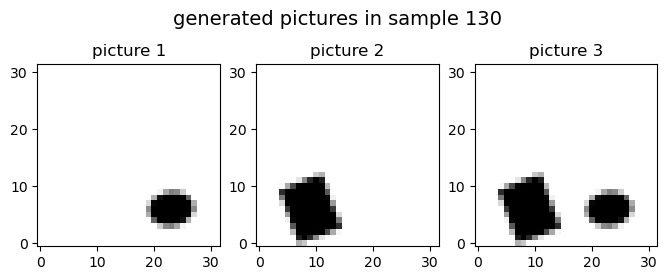

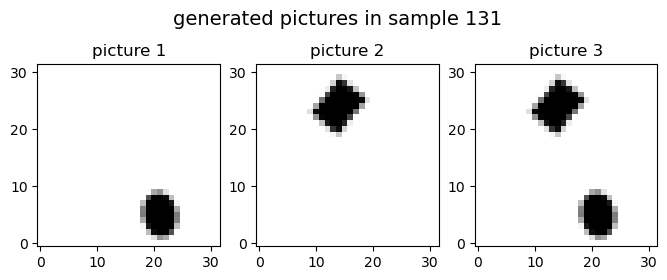

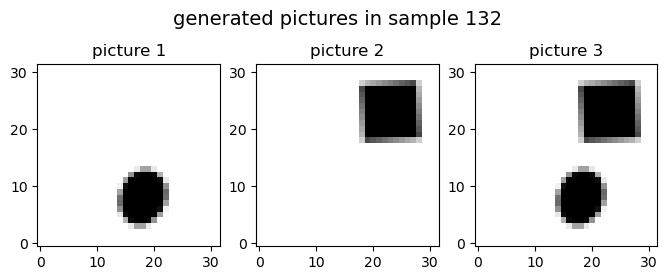

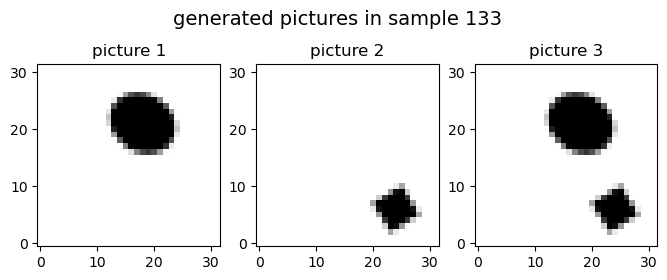

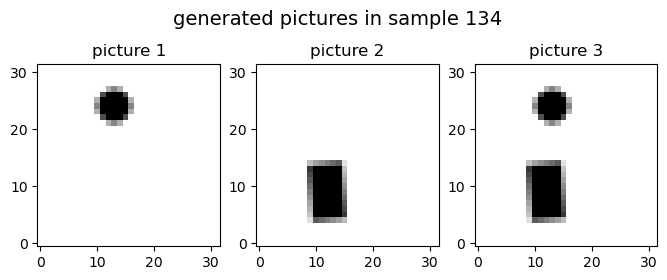

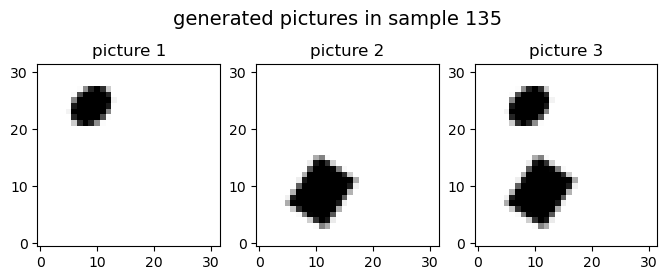

In [2]:
hf.pic_plt_sel(data=data_set,sample_low=130,sample_high=135)